In [1]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as ss
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import pymc.sampling.jax as pmjax
import jax

In [2]:
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

plt.rcParams["figure.figsize"] = [10, 7]

# Intro to PyMC

In this section, we work with a simple model for Bayesian inference. We draw some samples from a **Poisson distribution** with a known rate parameter $\lambda=2$. The idea of the following sections is to estimate this parameter from the data using Bayesian inference in PyMC.

In [3]:
# We set a seed so that the results are reproducible.
SEED = 5
np.random.seed(SEED)
# number of samples.
n = 10000000
# true parameter.
lam_true = 2
# sample array.
y = np.random.poisson(lam=lam_true, size=n)
y

array([2, 4, 1, ..., 2, 0, 2])

[Text(0.5, 1.0, 'Sample Distribution'), Text(0.5, 0, 'y')]

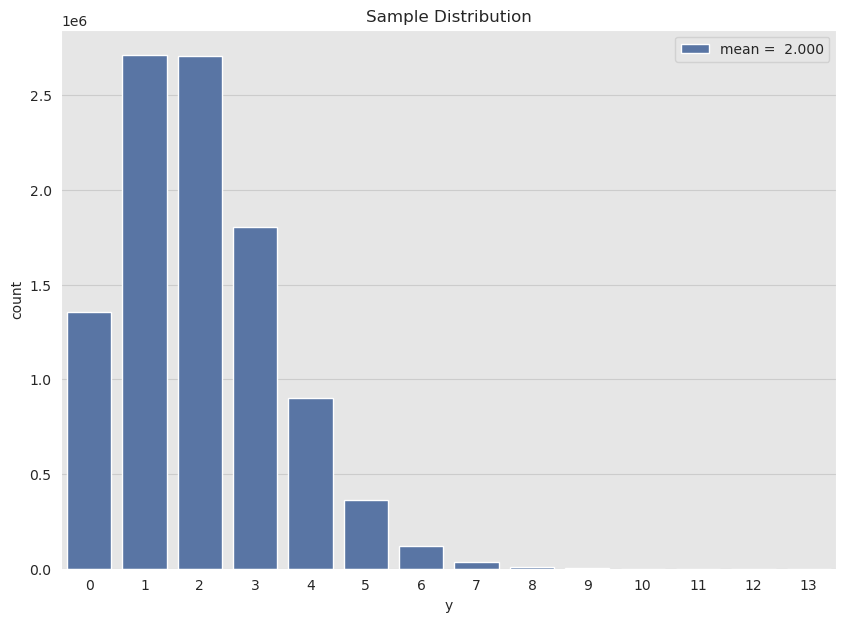

In [4]:
# Histogram of the sample.
fig, ax = plt.subplots()
sns.countplot(x=y, color=sns_c[0], label=f"mean = {y.mean(): 0.3f}", ax=ax)
ax.legend(loc="upper right")
ax.set(title="Sample Distribution", xlabel="y")

[Text(0.5, 1.0, 'Gamma Density Function for a=3 and b=1')]

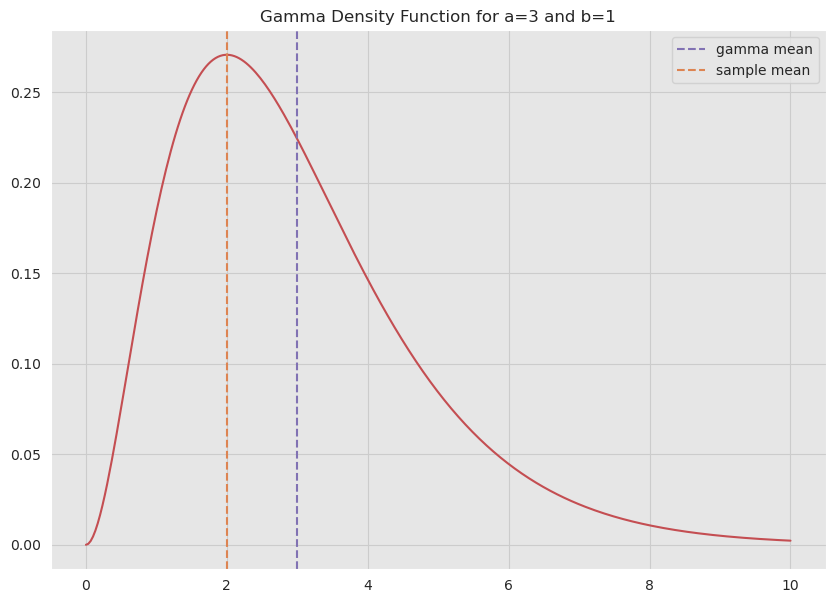

In [5]:
# Parameters of the prior gamma distribution.
a = 3  # shape
b = 1  # rate = 1/scale

x = np.linspace(start=0, stop=10, num=300)

fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1 / b), color=sns_c[3])
ax.axvline(x=a / b, color=sns_c[4], linestyle="--", label="gamma mean")
ax.axvline(x=y.mean(), color=sns_c[1], linestyle="--", label="sample mean")
ax.legend()
ax.set(title=f"Gamma Density Function for a={a} and b={b}")

## Define model

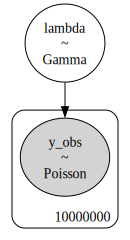

In [6]:
with pm.Model() as toy_model:
    # Define the prior of the parameter lambda.
    lam = pm.Gamma("lambda", alpha=a, beta=b)
    # Define the likelihood function.
    y_obs = pm.Poisson("y_obs", mu=lam, observed=y)

pm.model_to_graphviz(toy_model)

## Model estimation

In [7]:
with toy_model:
    # Consider 2000 draws and 4 chains.
    trace = pm.sample(
        tune=1000,
        draws=4000,
        chains=4,
        cores=16,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>]], dtype=object)

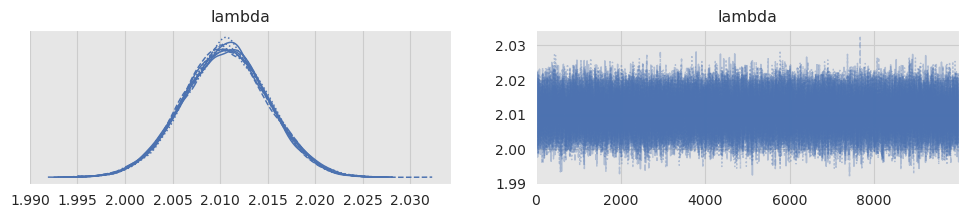

In [31]:
az.plot_trace(data=trace)

In [7]:
with toy_model:
    # Consider 2000 draws and 4 chains.
    # Inference (Sampling using NUTS)
    trace_gpu = pmjax.sample_numpyro_nuts(
        tune=1000,
        draws=4000,
        chains=4,
        cores=16,
        return_inferencedata=True,
        chain_method="vectorized",
    )

Compiling...
Compilation time =  0:00:06.638612
Sampling...


warmup:   2%|▏         | 82/5000 [01:29<1:29:00,  1.09s/it]


KeyboardInterrupt: 

array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>]], dtype=object)

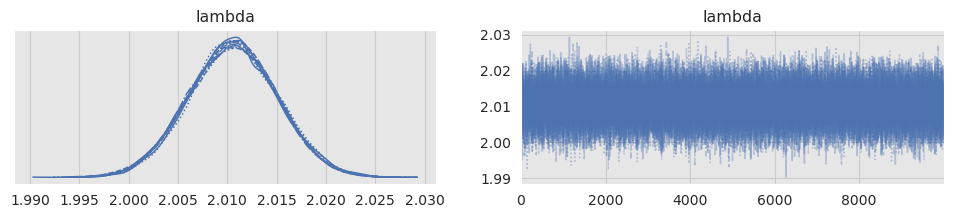

In [33]:
az.plot_trace(data=trace_gpu)

In [8]:
with toy_model:
    # Consider 2000 draws and 4 chains.
    # Inference (Sampling using NUTS)
    # Inference (Sampling using NUTS)
    trace_black = pmjax.sample_blackjax_nuts(
        tune=1000,
        draws=4000,
        chains=4,
        return_inferencedata=True,
        chain_method="vectorized",
    )

Compiling...
Compilation time =  0:00:09.120460
Sampling...


/home/andca/anaconda3/envs/pymc/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>]], dtype=object)

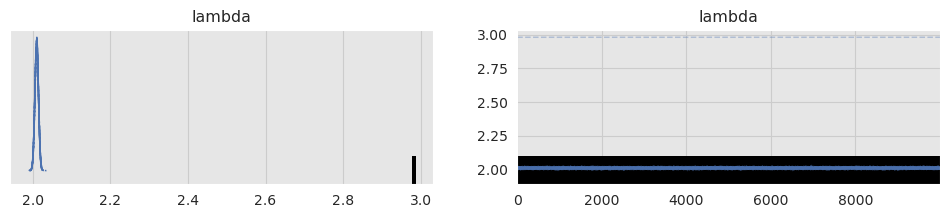

In [35]:
az.plot_trace(data=trace_black)

In [ ]:
aa

In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,2.066,0.145,1.793,2.327,0.003,0.002,2983.0,4726.0,1.0


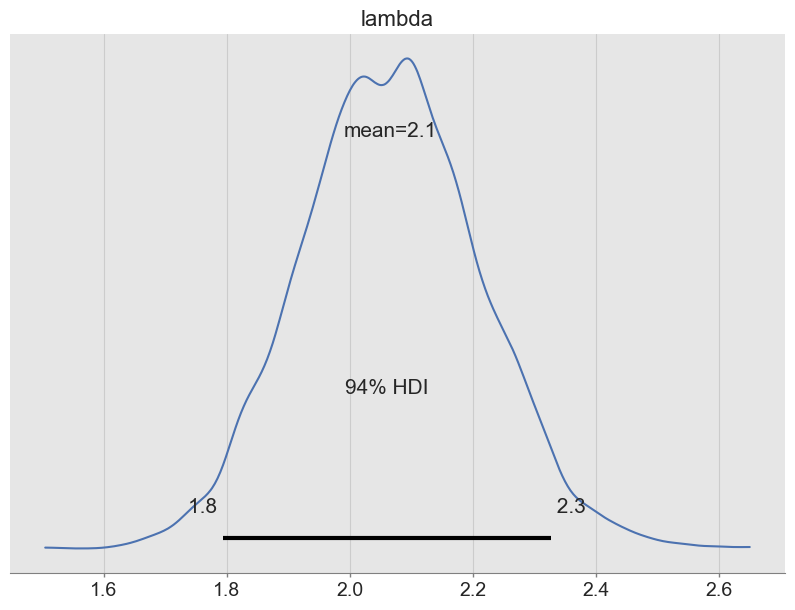

In [10]:
fig, ax = plt.subplots()
az.plot_posterior(data=trace, ax=ax);

## Model prediction

In [11]:
posterior_samples = pm.sample_posterior_predictive(trace=trace, model=toy_model, progressbar=False)

Sampling: [y_obs]


<Axes: ylabel='count'>

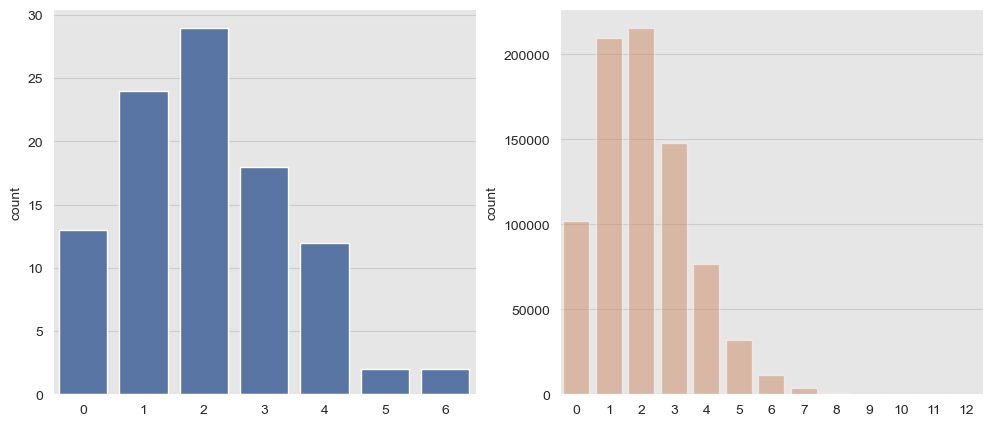

In [12]:
# plot the sample and the posterior predictive distribution.
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
sns.countplot(x=y, color=sns_c[0], label=f'mean = {y.mean(): 0.3f}', ax=ax[0])
sns.countplot(x=posterior_samples.posterior_predictive['y_obs'].values.flatten(), color=sns_c[1], label=f'mean = {posterior_samples.posterior_predictive["y_obs"].mean(): 0.3f}', ax=ax[1], alpha=0.5)

# Hierarchical model with PyMC

In this section, we build a hierarchical model for forecasting the chips count per cookie in a factory with 5 different locations. This type of models allows Bayesian inference by capturing the structure of the data using PyMC

### Read and explore data

Assume there is a big factory producing chocolate cookies around the world. The cookies follow a unique recipe. You want to study the chocolate chips distribution for cookies produced in 
5
 different locations. Let us read the data into a pandas dataframe.

In [13]:
cookies = pd.read_csv('cookies.dat', sep = ' ')
cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


In [14]:
cookies['location'].value_counts()

1    30
2    30
3    30
4    30
5    30
Name: location, dtype: int64

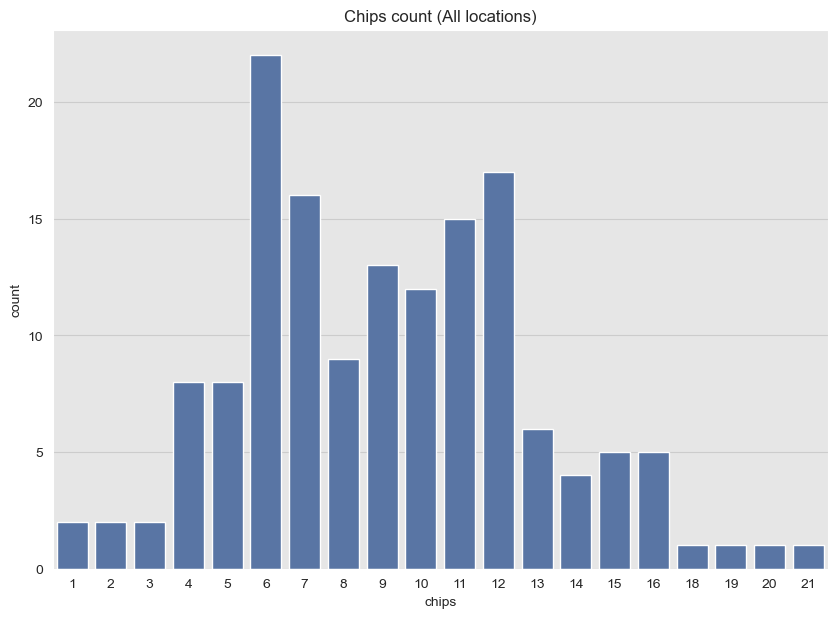

In [15]:
# Histogram of chips distribution in cookies for all locations
fig, ax = plt.subplots()
sns.countplot(x='chips', data=cookies, ax=ax, color=sns_c[0])
ax.set(title='Chips count (All locations)', xlabel='chips');

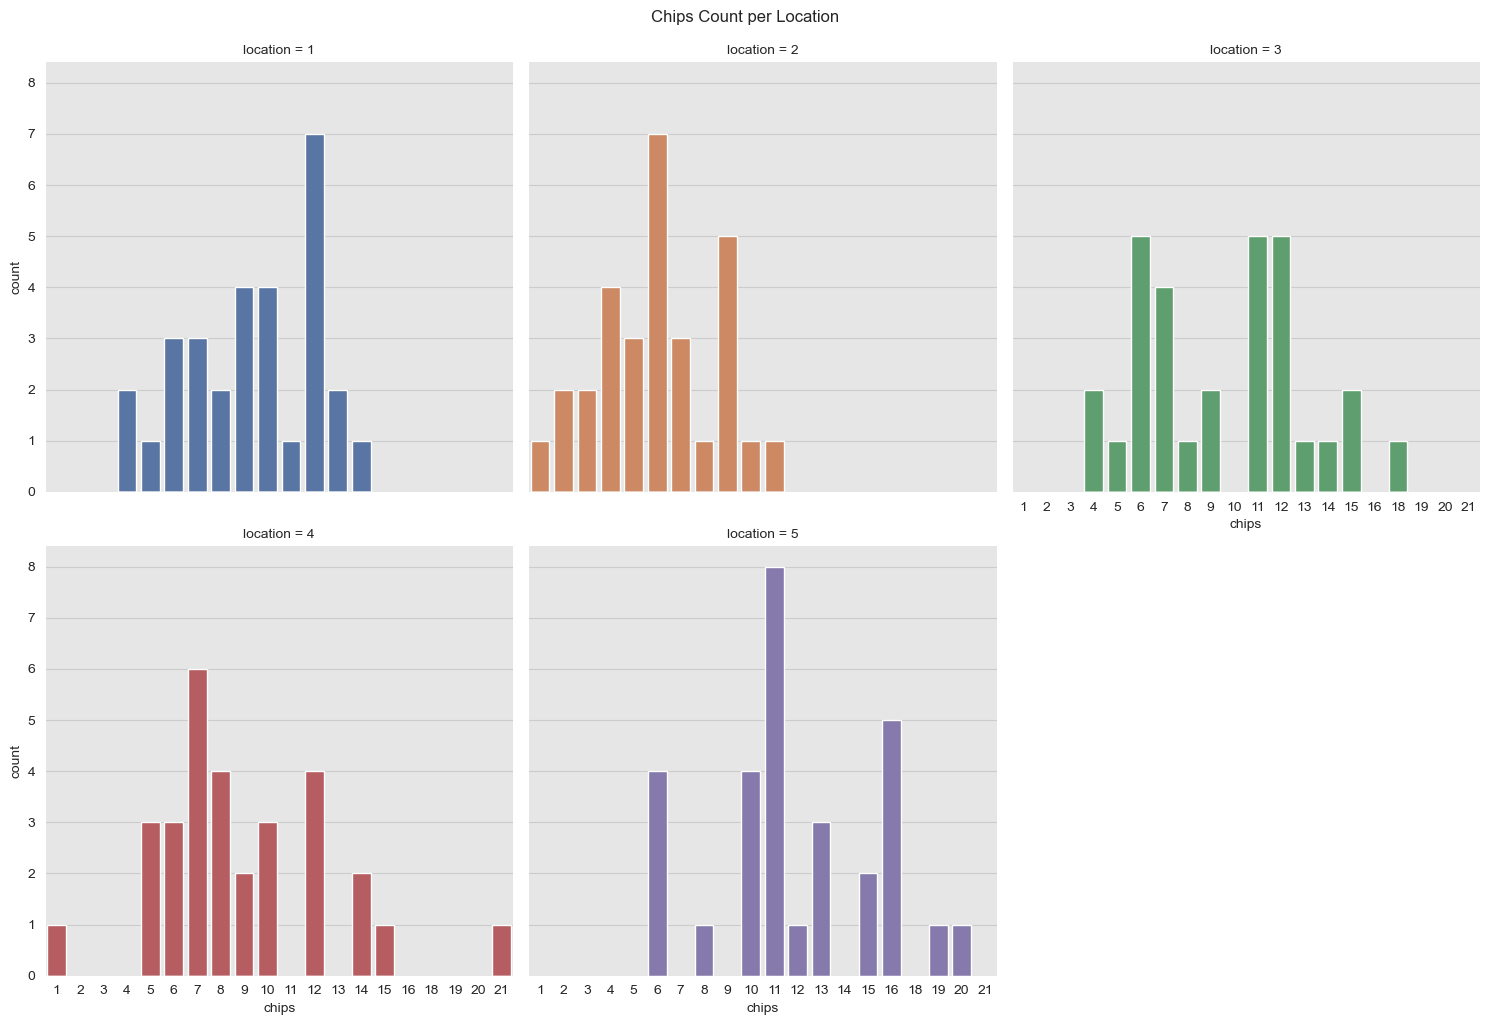

In [16]:
g = sns.catplot(x='chips', col='location', hue='location', data=cookies, kind='count', col_wrap=3, dodge=False)
g.fig.suptitle('Chips Count per Location', y=1.02);

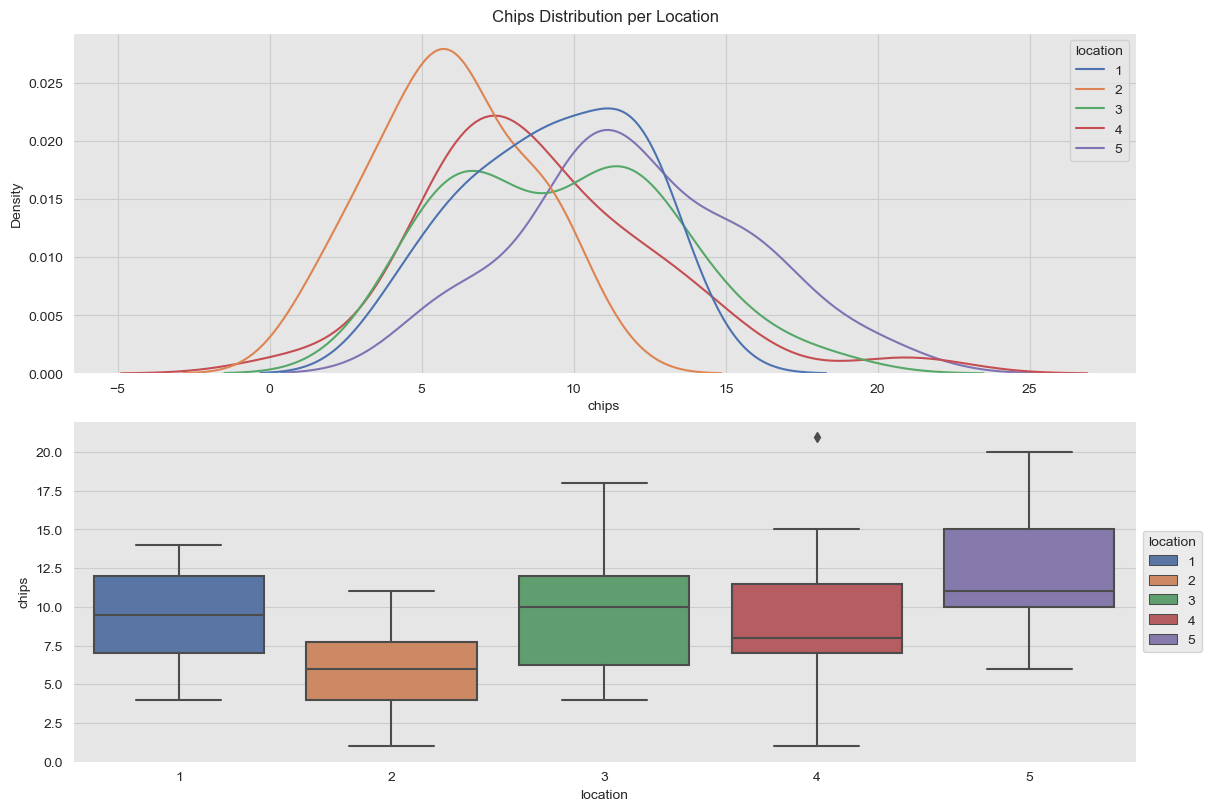

In [17]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True
)
sns.kdeplot(
    x='chips',
    data=cookies,
    hue='location',
    palette=sns_c[:5],ax=ax[0]
)
sns.boxplot(
    x='location',
    y='chips',
    data=cookies,
    hue='location',
    palette=sns_c[:5],
    dodge=False,
    ax=ax[1]
)
ax[1].legend(title='location', loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Chips Distribution per Location');

Based on these findings, we can approach this model by:

* Assuming that the chips distribution is the same for all locations, which results in a single model for all locations **(Pooled model)**
* Assuming that the chips distribution is different for each location, which results in a different model for each location **(Unpooled model or heterogeneous model)**

However, we can also assume that the chips distribution is different for each location, so the parameters of each distribution are different, but these parameters comes from a common global prior distribution (aka Hyper-prior distribution). This is one of the properties of a **hierarchical model**.

## The model: Hierarchical approach

* Hierarchical Model: We model the chocolate chip counts by a Poisson distribution with parameter $\lambda$. Motivated by the example above, we choose a gamma prior for this parameter.

$$
\begin{align}
chips \sim Poisson(\lambda) \text{,\ \ \ \  \  \   \ where } \lambda \sim \Gamma(\alpha, \beta)
\end{align}
$$

* Gamma parametrization: We use the parametrization of the gamma distribution with mean $\mu$ and standard deviation $\sigma$.

$$
\begin{align}
\alpha = \frac{\mu^2}{\sigma^2} \text{,\ \ \ \  \  \   \ and } \beta = \frac{\mu}{\sigma^2}
\end{align}
$$

* Hyper-prior distribution: we further assume that the parameters $\mu$ and $\sigma$ come from a common prior distribution. We choose a gamma distribution for $\mu$ and a exponential distribution for $\sigma$.

$$
\begin{align}
\mu \sim \Gamma(2, 1.5) \text{,\ \ \ \  \  \   \ and } \sigma \sim Exp(1)
\end{align}
$$

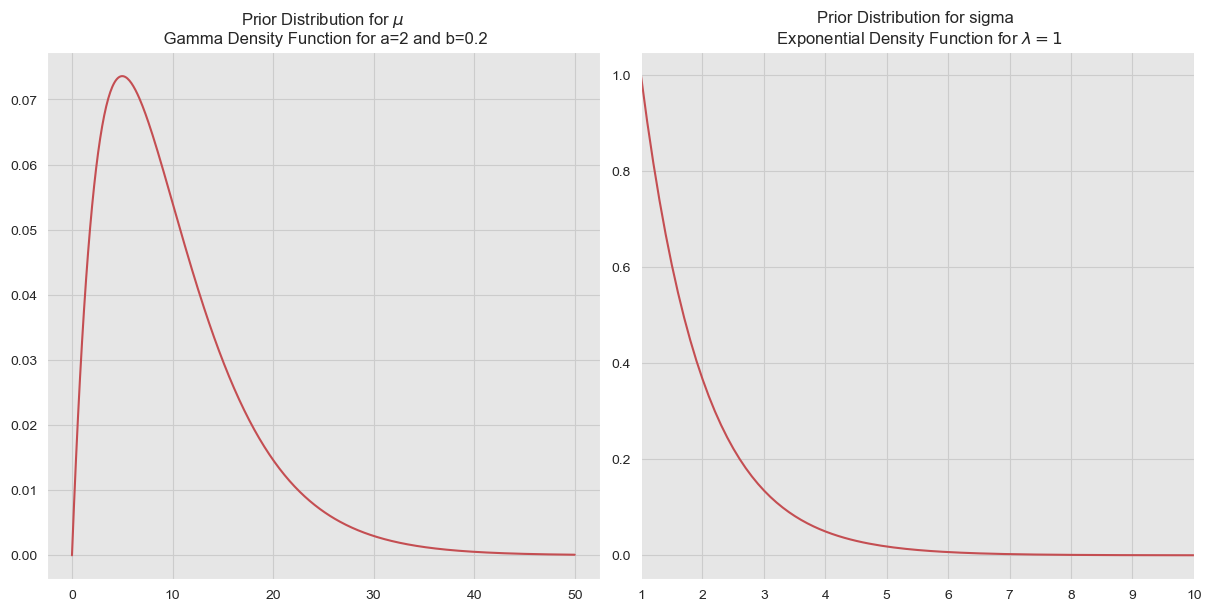

In [18]:
x = np.linspace(start=0, stop=50, num=500)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True
)
ax[0].plot(x, ss.gamma.pdf(x, a=2, scale=5), color=sns_c[3])
ax[0].set(
    title=f'Prior Distribution for $\mu$ \n Gamma Density Function for a={2} and b={1/5}'
)
ax[1].plot(x, ss.expon.pdf(x,1), color=sns_c[3])
ax[1].set(
    title='Prior Distribution for sigma \n Exponential Density Function for $\lambda=1$',
    xlim=(1, 10)
);

We will do some prior predictive sampling to understand the choice of these priors.

Let us write the model in PyMC. Note how the syntax mimics the mathematical formulation.



In [23]:
# Define useful variables and coordinates in order to 
# specify shapes of the distributions.
chips = cookies['chips'].values
location_idx, locations = cookies['location'].factorize(sort=True)

COORDS = {
    'obs': cookies.index,
    'location': locations
}

Sampling: [lam, likelihood, mu, sigma]


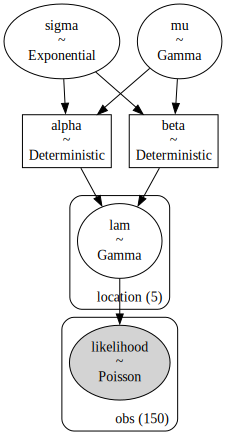

In [24]:
with pm.Model(coords=COORDS) as cookies_model:
    #### Hyperpriors:
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)

    #### Parametrization of the priors:
    # Parametrization for the shape parameter.
    alpha =  pm.Deterministic('alpha', mu**2 / sigma**2)
    # Parametrization for the scale parameter.
    beta = pm.Deterministic('beta', mu / sigma**2)

    #### Priors definition:
    # Prior distribution for lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        dims='location'
    )

    # Likehood function.
    rate = lam[location_idx]
    likelihood = pm.Poisson(
        'likelihood',
        mu=rate,
        observed=chips,
        dims='obs'
    )

    # Sample prior distribution.
    prior_predictive = pm.sample_prior_predictive(return_inferencedata=False)

pm.model_to_graphviz(cookies_model)

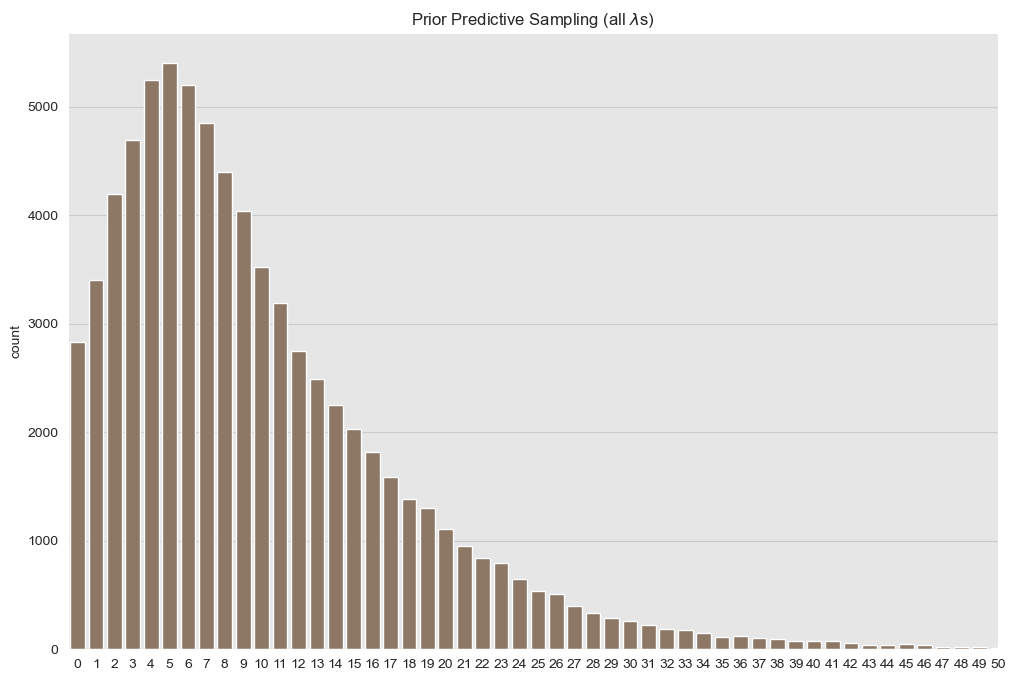

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(
    x=prior_predictive['likelihood'].flatten(), 
    color=sns_c[5],
    ax=ax
)
ax.set(
    title='Prior Predictive Sampling (all $\lambda$s)', 
    xlim=(None, 50)
);

In [95]:
with cookies_model:

    cookies_trace = pm.sample(
        tune=1000,
        draws=5000,
        chains=4,
        cores=16,
        return_inferencedata=True,
        target_accept=0.95,
        idata_kwargs = {'log_likelihood': True}
    )

    posterior_predictive=pm.sample_posterior_predictive(trace=cookies_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [mu, sigma, lam]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.
Sampling: [likelihood]


## Evaluating the model

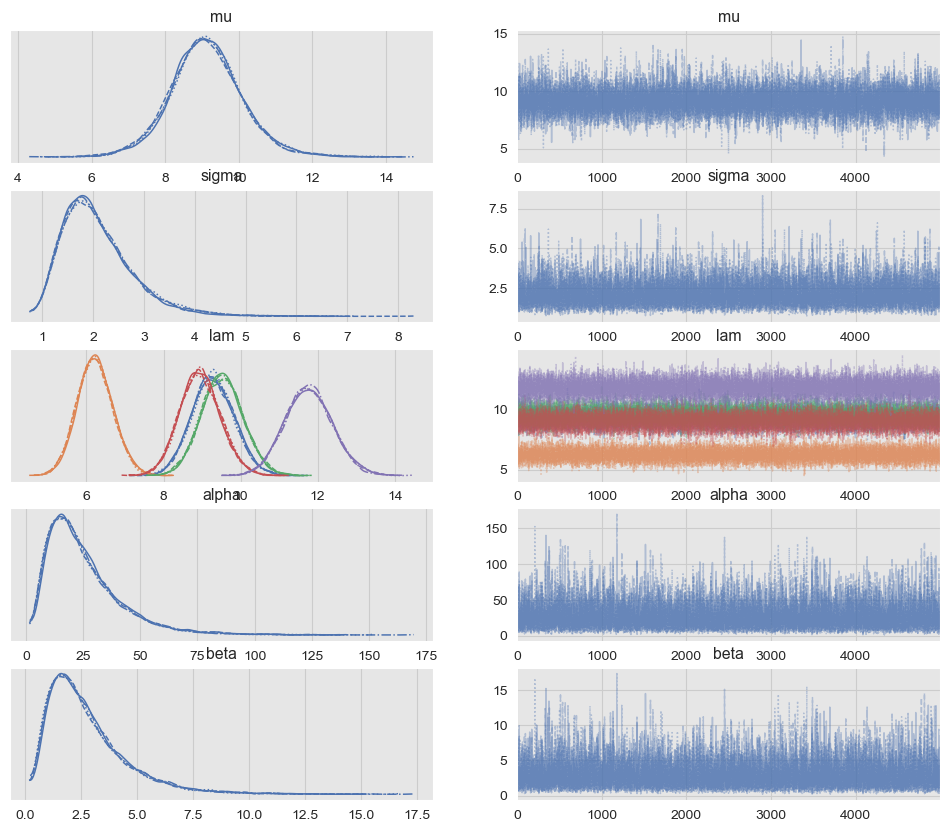

In [96]:
az.plot_trace(cookies_trace);

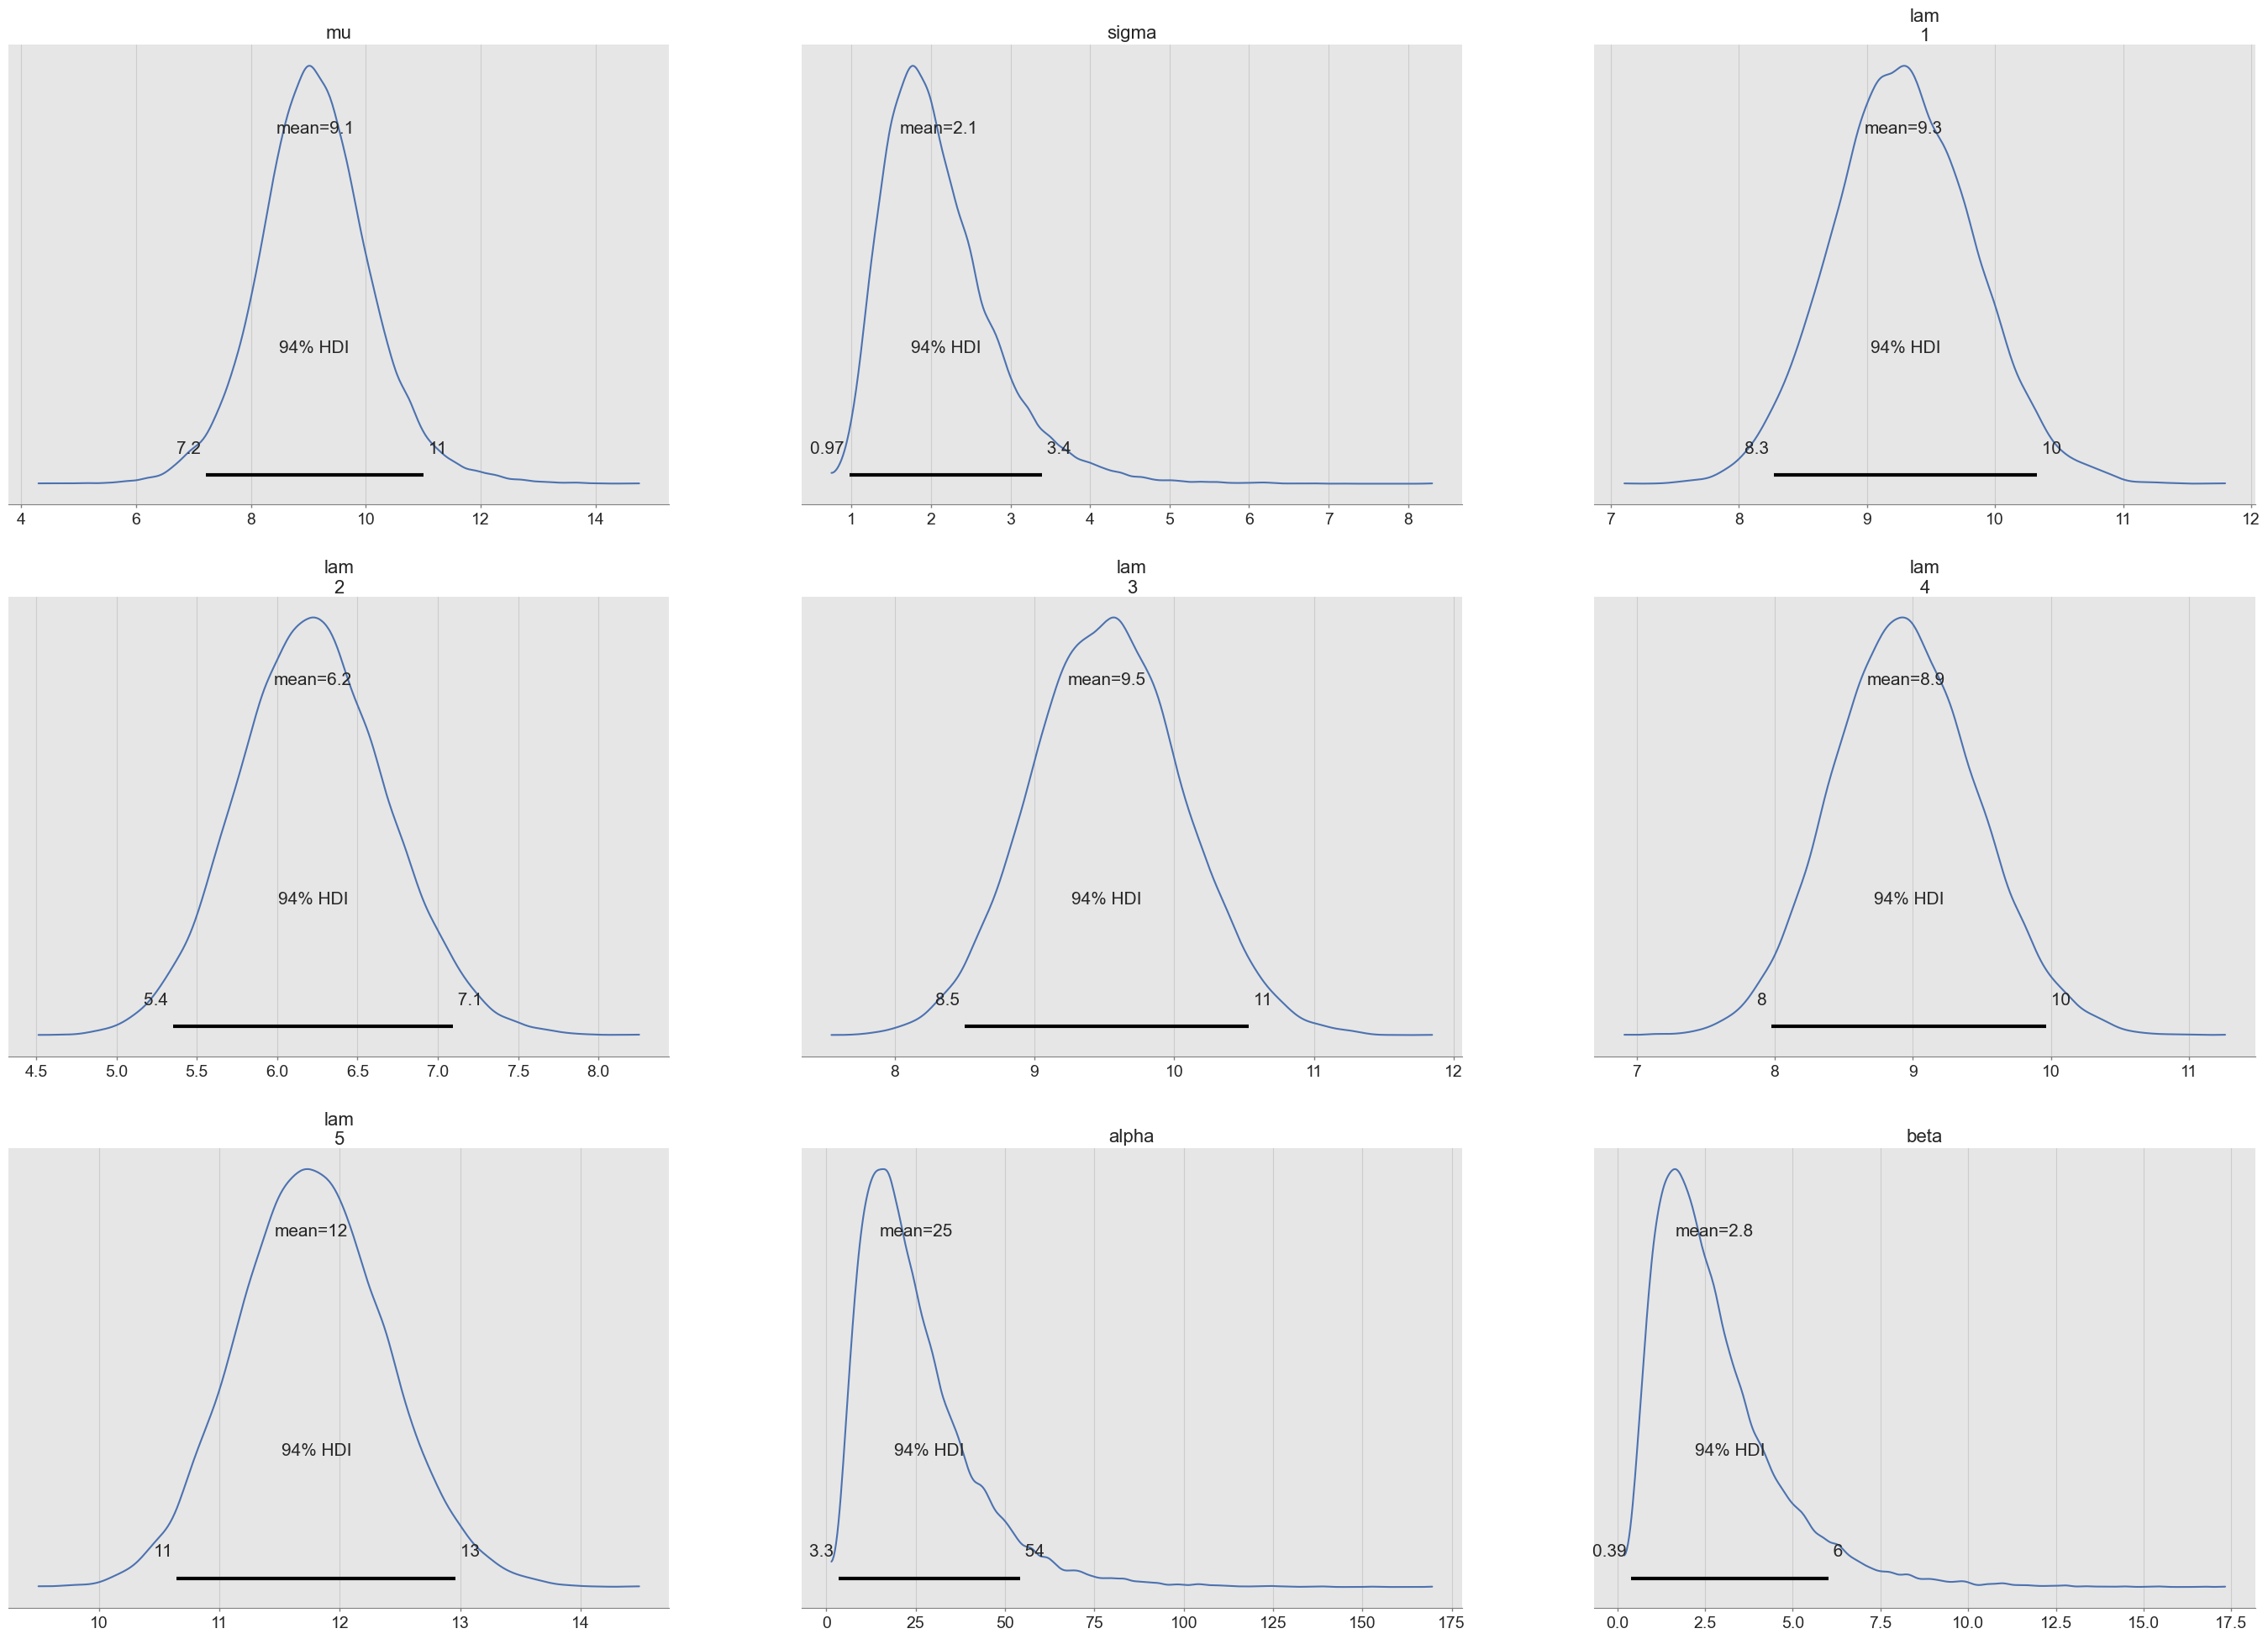

In [97]:
az.plot_posterior(cookies_trace);

In [98]:
az.summary(cookies_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.121,0.996,7.209,11.000,0.008,0.006,14667.0,10962.0,1.0
sigma,2.095,0.710,0.974,3.399,0.006,0.004,13626.0,13945.0,1.0
lam[1],9.285,0.548,8.274,10.329,0.004,0.003,21704.0,15069.0,1.0
lam[2],6.224,0.464,5.352,7.094,0.004,0.002,17512.0,14711.0,1.0
lam[3],9.519,0.542,8.499,10.532,0.004,0.003,22862.0,14445.0,1.0
lam[4],8.948,0.527,7.976,9.962,0.004,0.003,22149.0,14946.0,1.0
lam[5],11.765,0.619,10.645,12.963,0.005,0.003,18382.0,14673.0,1.0
alpha,25.161,16.298,3.324,54.195,0.135,0.099,14134.0,14015.0,1.0
beta,2.769,1.790,0.394,6.014,0.015,0.011,13805.0,14931.0,1.0


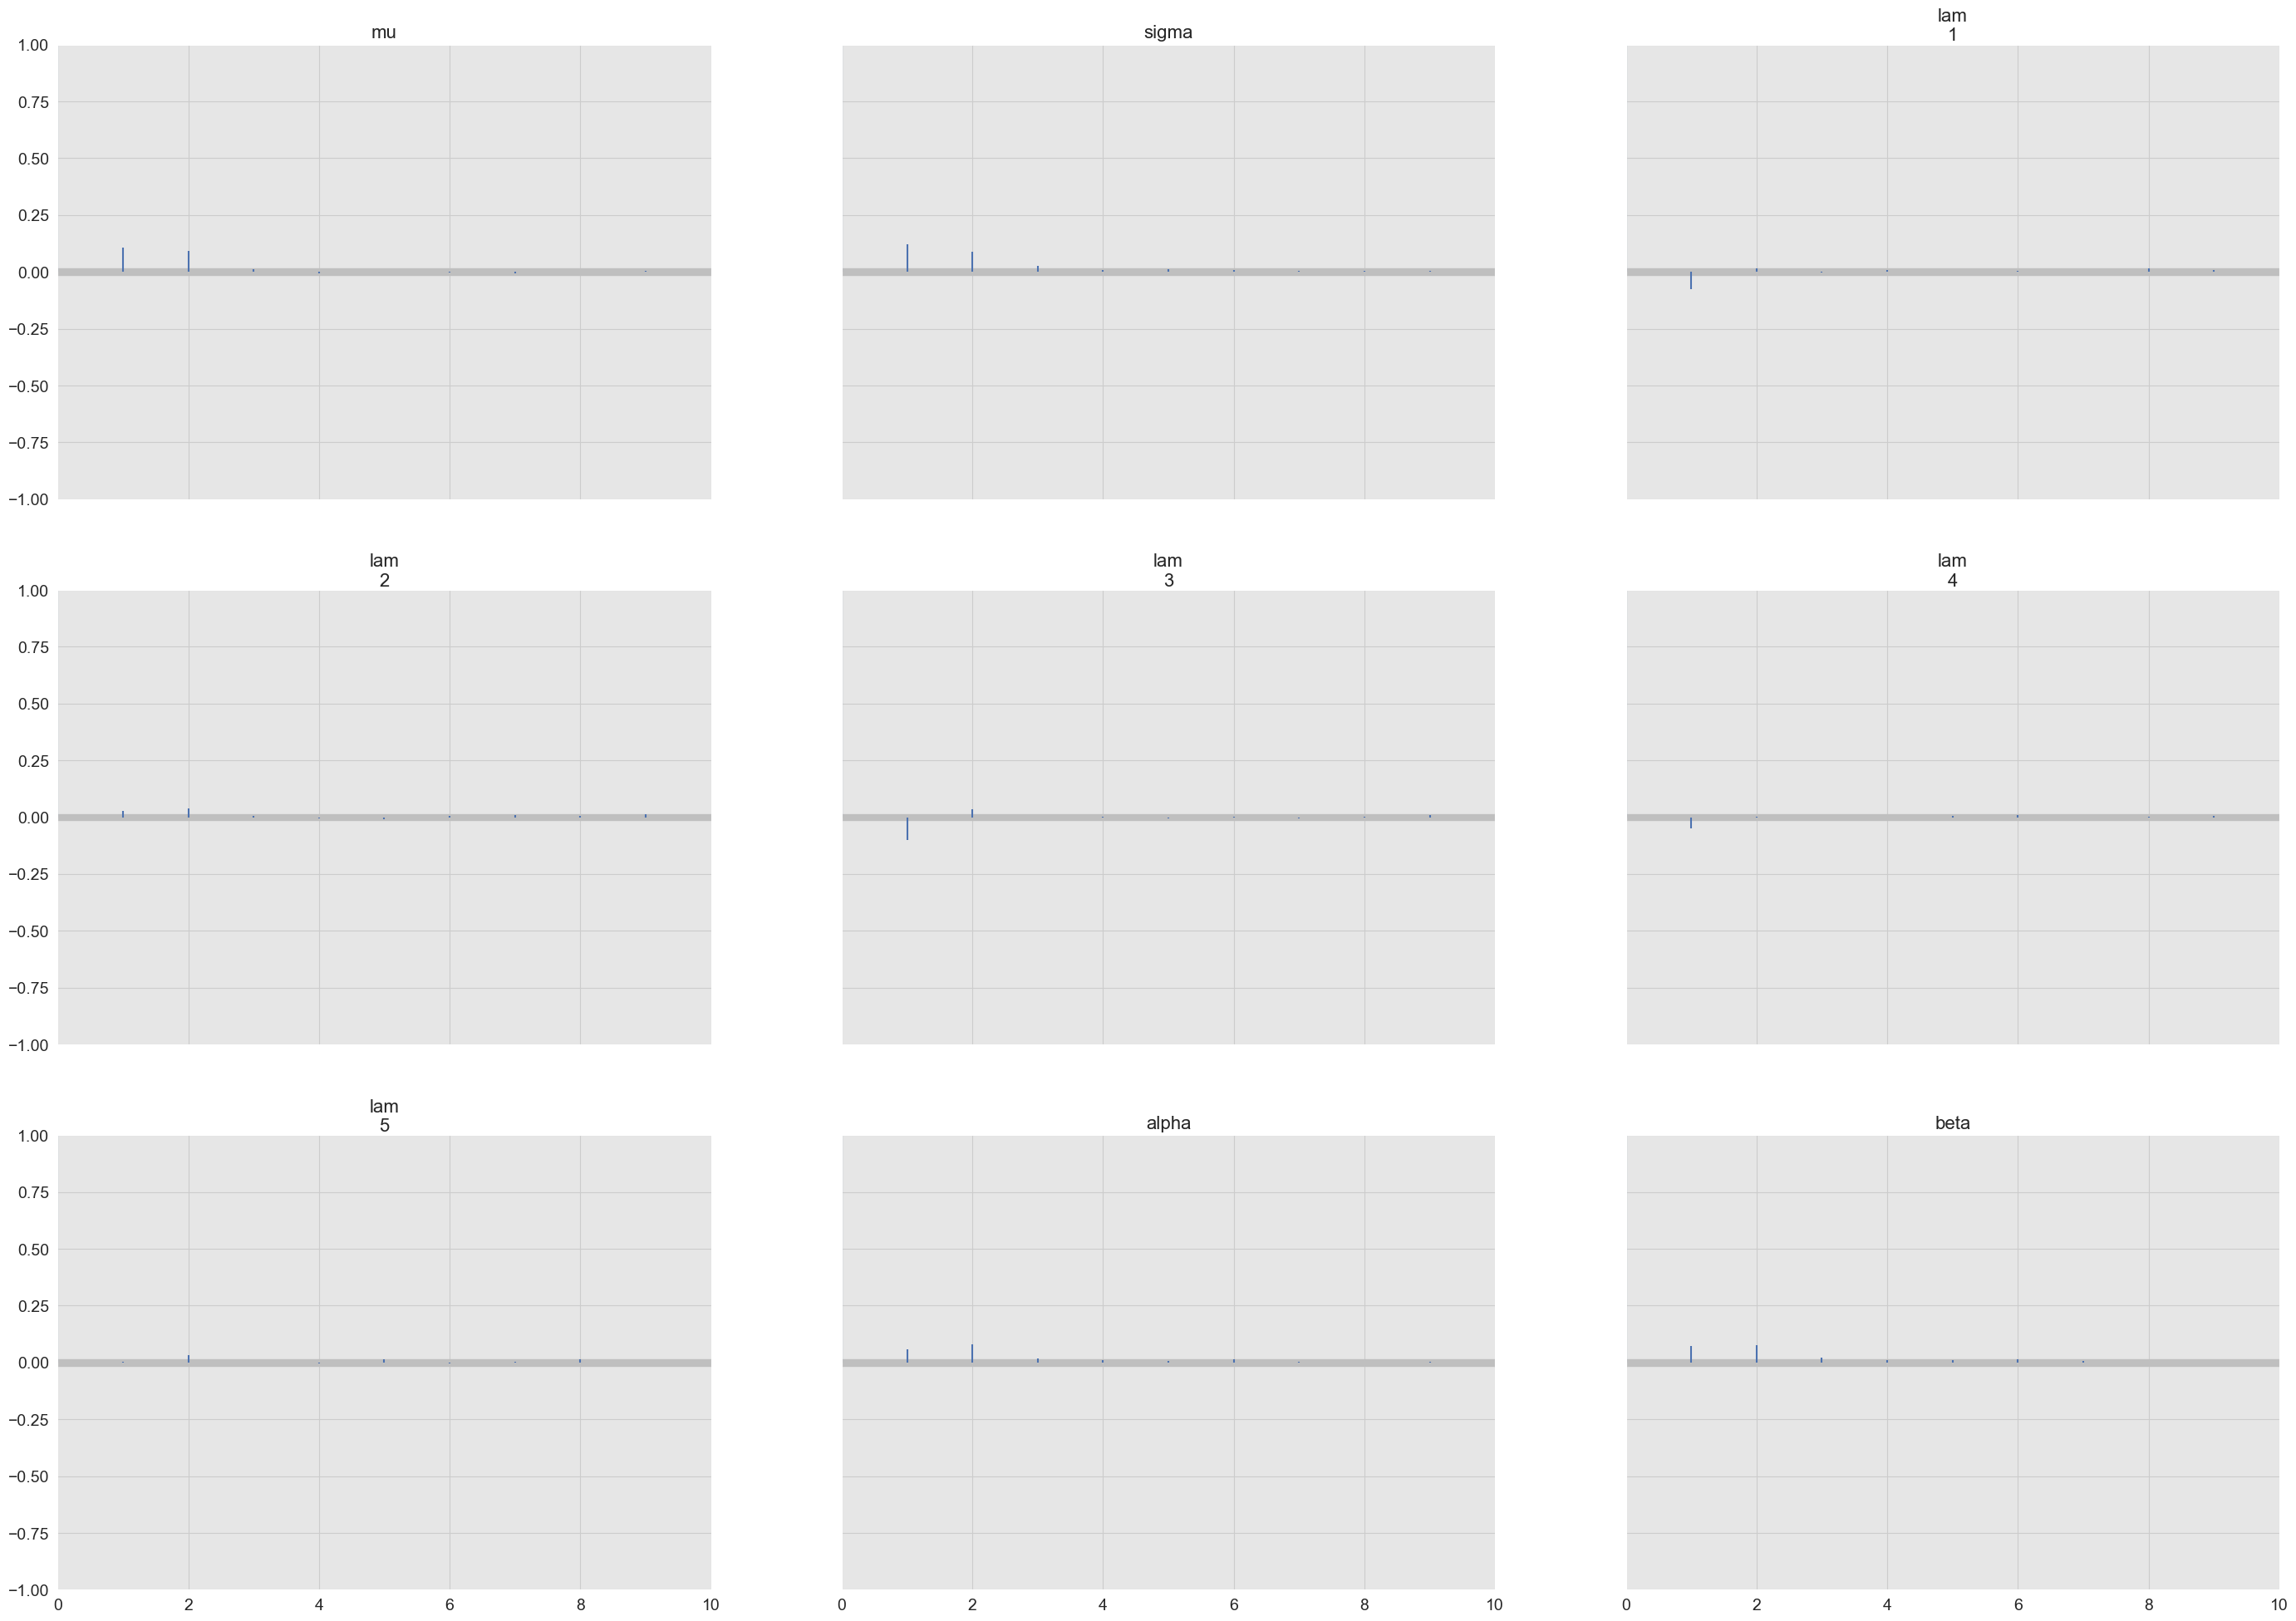

In [99]:
# Auto-correlation of the parameters
az.plot_autocorr(data=cookies_trace, combined=True, max_lag=10);

In [100]:
stats_df = pd.concat([
    pd.DataFrame(az.loo(data=cookies_trace)),
    pd.DataFrame(az.waic(data=cookies_trace))
])
stats_df.columns = ['values']

stats_df 

c:\Users\andca\.conda\envs\thesis\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,values
elpd_loo,-394.848927
se,10.677665
p_loo,5.801523
n_samples,20000
n_data_points,150
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()>\narray(-2.56625...
pareto_k,[<xarray.DataArray 'pareto_shape' ()>\narray(0...
scale,log
elpd_waic,-394.83716


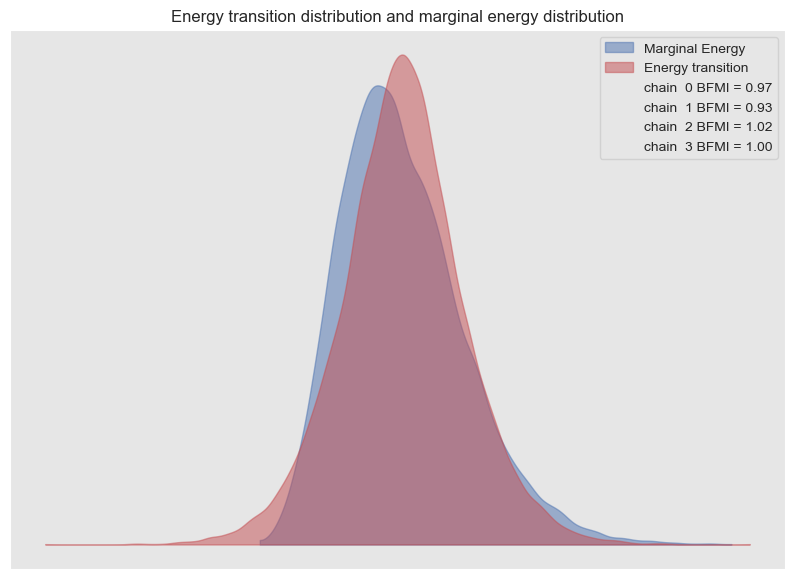

In [101]:
fig, ax = plt.subplots()

az.plot_energy(
    data=cookies_trace,
    fill_color=('C0', 'C3'),
    fill_alpha=(0.5, 0.5),
    ax=ax
)
ax.set(
    title='Energy transition distribution and marginal energy distribution'
);

## Posterior predictive checks (PPC's)

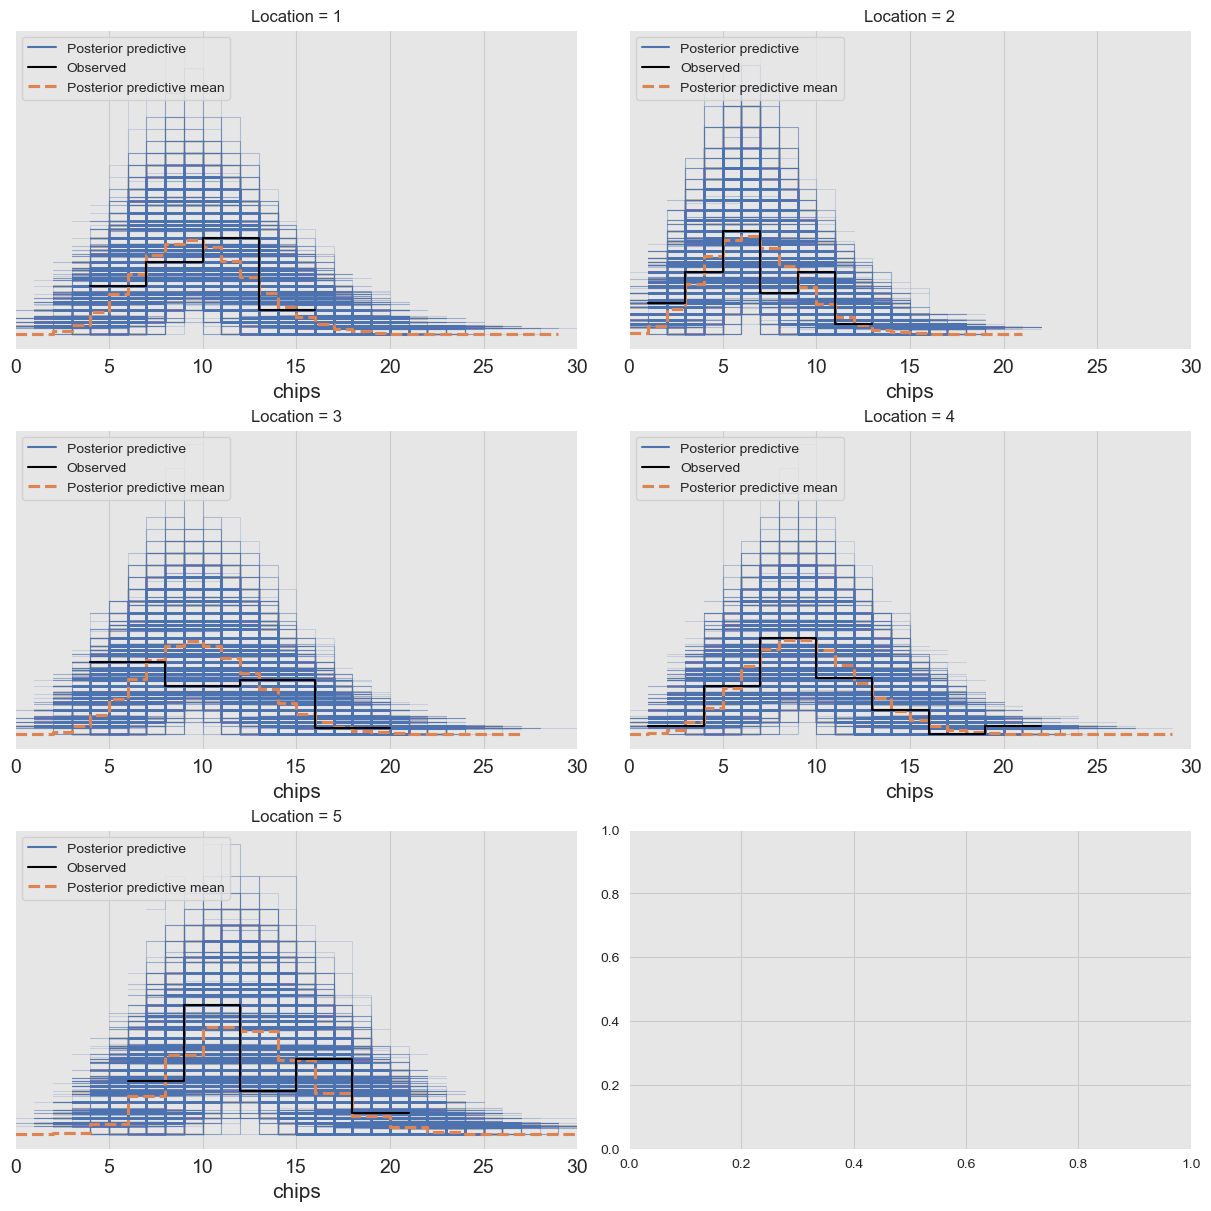

In [103]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 12),
    constrained_layout=True
)

axes = axes.flatten()

for i, location in enumerate(locations):
    ax = axes[i]
    az.plot_ppc(
        data=posterior_predictive,
        coords={
            'obs': np.where(locations[location_idx] == location)
        },
        ax=ax,
        alpha=0.2,
    )
    ax.legend(loc='upper left')
    ax.set(
        title=f'Location = {location}',
        xlabel='chips',
        xlim=(0, 30)
    )


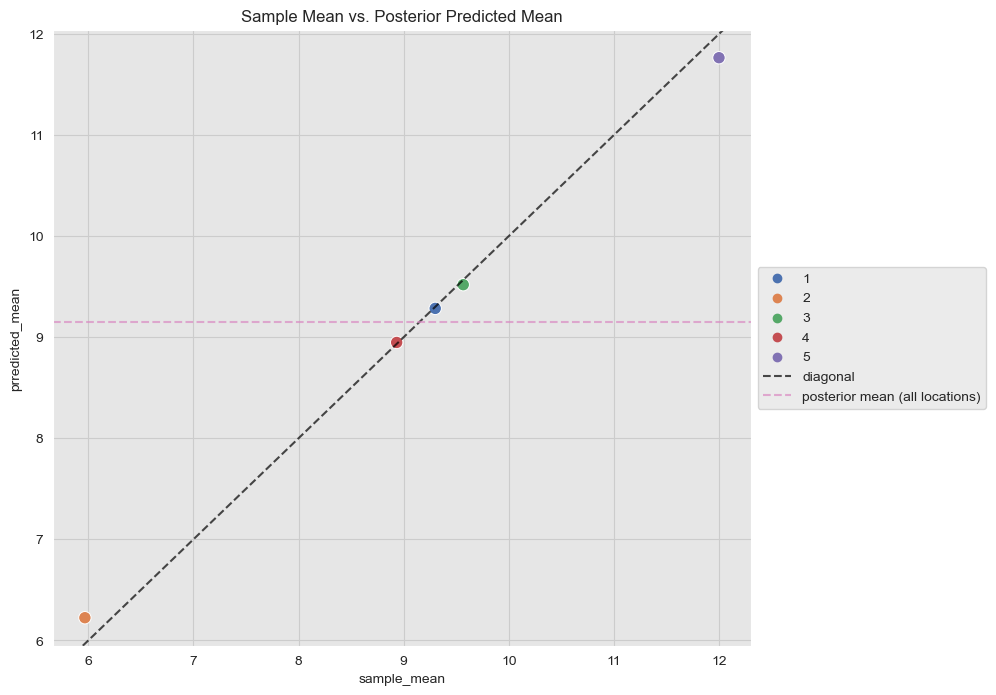

In [104]:
posterior_predictive_mean_lam = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    .lam \
    .mean(axis=1)

posterior_predictive_mean_all_lam = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw', 'location')) \
    .lam \
    .mean()

fig, ax = plt.subplots(figsize=(9, 8))

cookies \
    .groupby('location', as_index=False) \
    .agg(sample_mean=('chips', np.mean)) \
    .assign(prredicted_mean = posterior_predictive_mean_lam) \
    .pipe((sns.scatterplot, 'data'),
        x='sample_mean',
        y='prredicted_mean',
        hue='location',
        palette=sns_c[:5],
        s=80,
        ax=ax
    )

ax.axline(
    xy1=(9, 9),
    slope=1,
    color='black',
    linestyle='--',
    alpha=0.7,
    label='diagonal'

)
ax.axhline(
    y=posterior_predictive_mean_all_lam,
    color=sns_c[6],
    linestyle='--',
    alpha=0.7,
    label='posterior mean (all locations)'
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(
    title='Sample Mean vs. Posterior Predicted Mean',
);

Note that locations 1, 3 and 4 are over the diagonal, which means that the sample and posterior predictive mean are pretty much the same. These values are actually quite close to the global posterior predictive mean. On the other hand locations 2 and 5 have higher and lower expected prediction means respectively. The reason is that the hierarchical model is trying to push them close to the global posterior mean. This phenomenon is called shrinkage and can be seen as a kind of regularization.

## Inference for existing location (in-sample)

Let us deep dive in location = 1. We want, for example, to compute the posterior probability that the next cookie generated in this location will have less that 7
 chips. First let us start by looking into the posterior distribution of λ for this location.

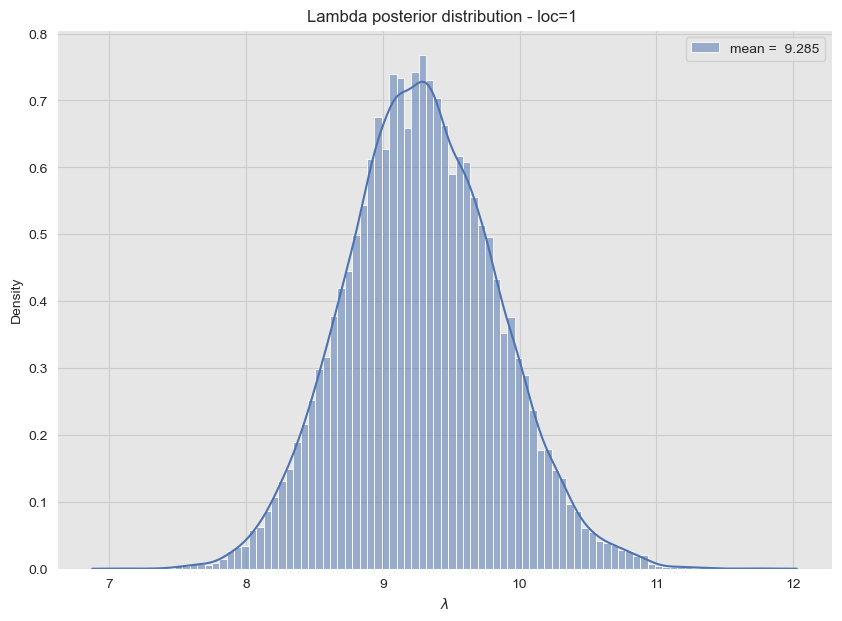

In [206]:
# Set location.
loc = 1
# Get posterior samples.
lambda_loc = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][loc - 1, :].values
# Plot distribution.
fig, ax = plt.subplots()
sns.histplot(
    x=lambda_loc,
    stat='density',
    color=sns_c[0],
    alpha=0.5,
    label=f'mean = {lambda_loc.mean(): 0.3f}',
    ax=ax
)
sns.kdeplot(
    x=lambda_loc,
    color=sns_c[0],
    ax=ax
)
ax.legend()
ax.set(title=f'Lambda posterior distribution - loc={loc} ', xlabel='$\lambda$');

Next, let us use these values and sample from a Poisson distribution to get the chips distribution.

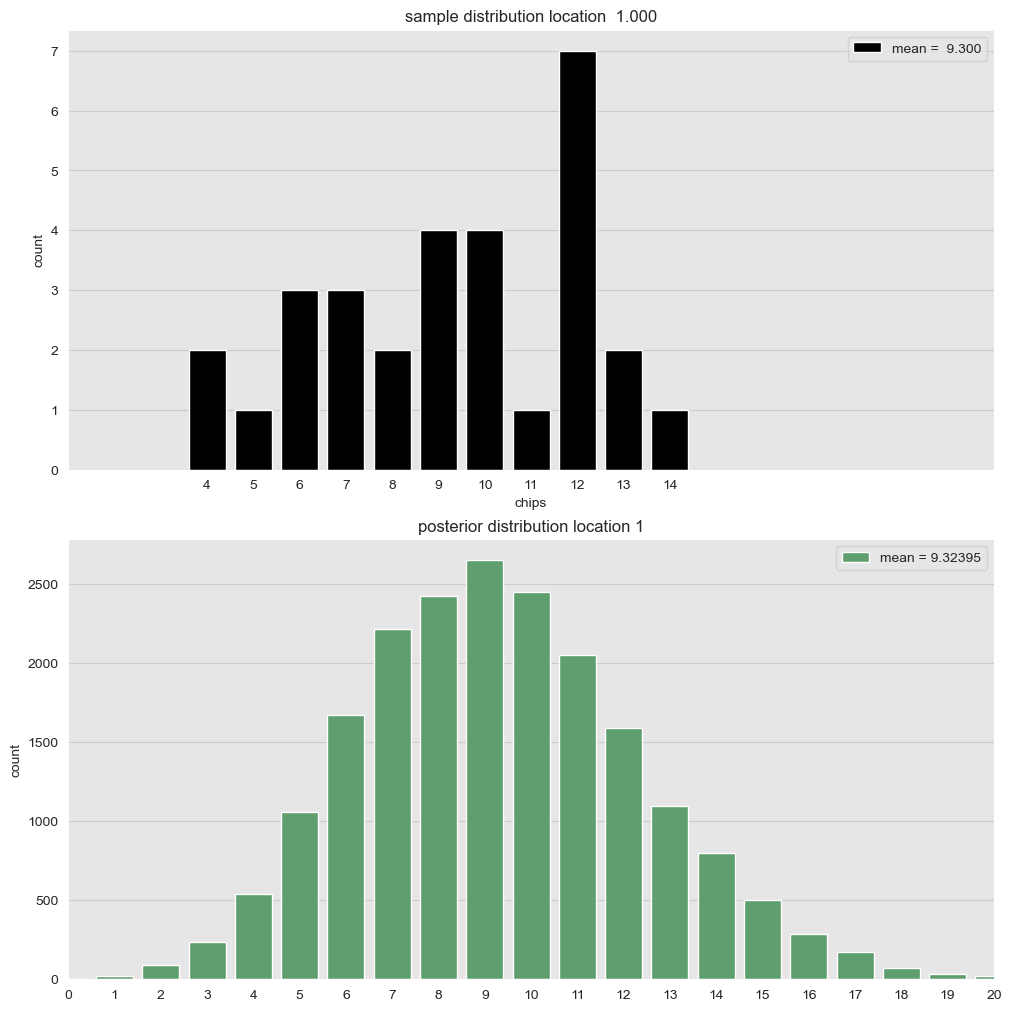

In [207]:
SEED = 5
np.random.seed(SEED)
# Sample from Poisson distribution using posterior samples from lambda.
samples_loc = np.random.poisson(lam=lambda_loc)
# Plot samples vs posterior distribution.
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 10), constrained_layout=True
)
sns.countplot(
    x='chips',
    data=cookies.query(f'location == {loc}'),
    color='black',
    label=f'mean = {cookies.query(f"location == {loc}")["chips"].mean(): 0.3f}',
    ax=ax[0]
)
ax[0].legend(loc='upper right')
ax[0].set(
    title=f'sample distribution location {loc: 0.3f}',
    xlim=(-3, 17)
)
sns.countplot(
    x=samples_loc,
    color=sns_c[2],
    label=f'mean = {samples_loc.mean()}',
    ax=ax[1]
)
ax[1].legend(loc='upper right')
ax[1].set(
    title=f'posterior distribution location {loc}',
    xlim=(0, 20)
);

Let us now compute the desired probability:

In [209]:
((samples_loc < 7)).astype(float).mean()

0.1808

**Remark:** We can also compute this probability using the posterior_predictive object directly.

In [210]:
samples_loc = posterior_predictive \
    .posterior_predictive \
    .stack(sample=('chain', 'draw')) \
    ['likelihood'][locations[location_idx] == loc] \
    .values \
    .flatten()

(samples_loc < 7).astype(float).mean()

0.18678166666666668

## Inference for new location (out-of-sample)

Now assume we want to open a new location. First, we want to compute the posterior probability that this new location has 
$λ_{new}>15$. To do so, as we do not have data from new locations, we can start by sampling from the (hyper)-prior distribution:

In [218]:
alpha_samples = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['alpha'].values

beta_samples = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['beta'].values

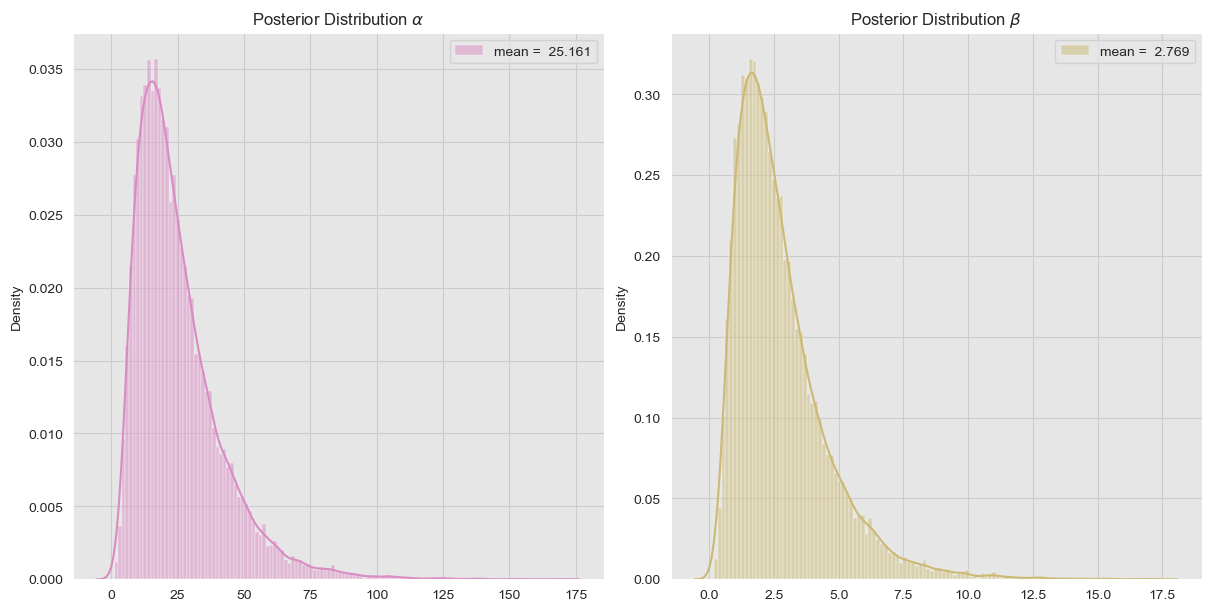

In [221]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True
)
sns.histplot(
    x=alpha_samples,
    stat='density',
    alpha=0.5,
    color=sns_c[6],
    label=f'mean = {alpha_samples.mean(): 0.3f}',
    ax=ax[0]
)
sns.kdeplot(
    x=alpha_samples,
    color=sns_c[6],
    ax=ax[0]
)
ax[0].legend()
ax[0].set(title=r'Posterior Distribution $\alpha$')
sns.histplot(
    x=beta_samples,
    stat='density',
    alpha=0.5,
    color=sns_c[8],
    label=f'mean = {beta_samples.mean(): 0.3f}',
    ax=ax[1]
)
sns.kdeplot(
    x=beta_samples ,
    color=sns_c[8],
    ax=ax[1]
)
ax[1].legend()
ax[1].set(title=r'Posterior Distribution $\beta$');

Next we sample to the the distribution of $\lambda_{new}$

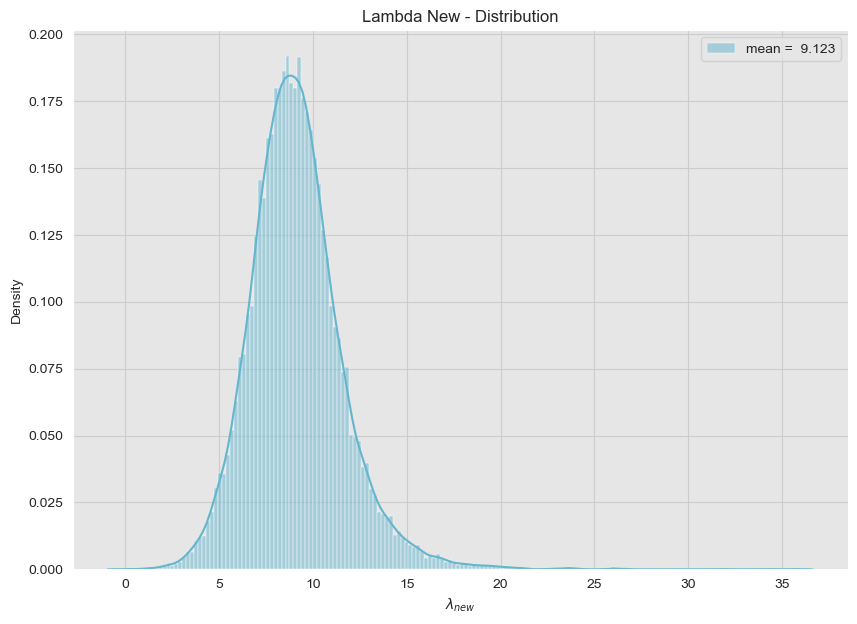

In [222]:
lambda_new_samples = np.random.gamma(alpha_samples, 1/beta_samples)

fig, ax = plt.subplots()
sns.histplot(
    x=lambda_new_samples,
    stat='density',
    alpha=0.5,
    color=sns_c[9],
    label=f'mean = {lambda_new_samples.mean(): 0.3f}',
    ax=ax
)
sns.kdeplot(
    x=lambda_new_samples,
    color=sns_c[9],
    ax=ax
)
ax.legend()
ax.set(title=f'Lambda New - Distribution', xlabel='$\lambda_{new}$');

To compute the desired probability we can simply do:

In [223]:
(lambda_new_samples > 15).astype(float).mean()

0.0199

Finally, for this new location, we wan to estimate the probability for a cookie to have more than 10 chocolate chips. To do so we move to the next level in our hierarchical model. We sample from a Poisson distribution using the samples obtained for $\lambda_{new}$.

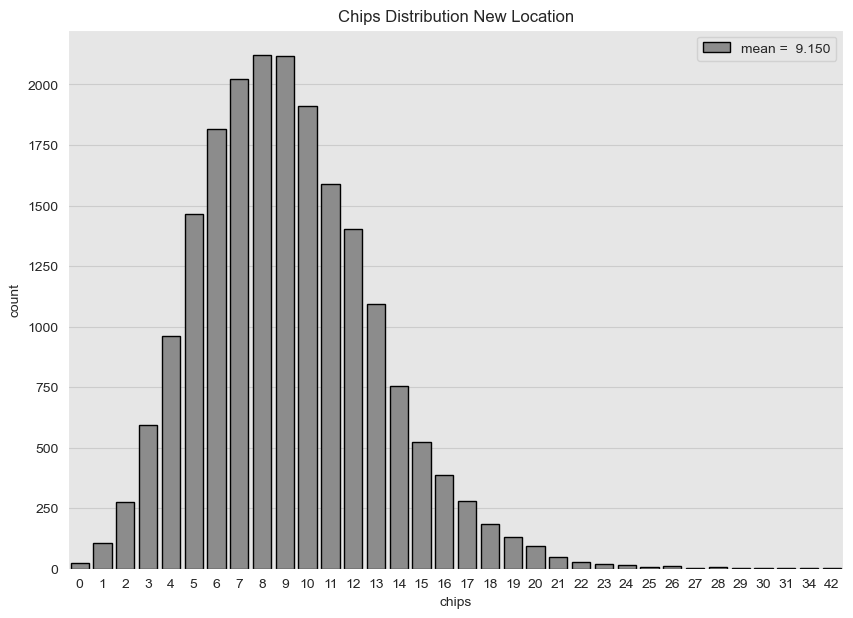

In [225]:
chips_new_location = np.random.poisson(lam=lambda_new_samples)

fig, ax = plt.subplots()
sns.countplot(
    x=chips_new_location,
    color=sns_c[7],
    edgecolor='black',
    label=f'mean = {chips_new_location.mean(): 0.3f}',
    ax=ax
)
ax.legend()
ax.set(title=f'Chips Distribution New Location', xlabel='chips');

We now can estimate the required probability:

In [227]:
(chips_new_location > 10).astype(float).mean()

0.32975